## Experiment: Comparing Performance of Two Mutation Methods for Large Random Graphs (n = 1000)

This notebook documents the implementation and results of a set of tests for the proposed GA for the static SSSP problem with large graphs of one thousand nodes, with two distinct mutation methods. 

The first mutation method **mutation_a** selects a random node (excl. start and destination) and replaces the subpath to the destination node with a new randomly generated path. 

The second mutation method **mutation_b** selects a random node (excl. start and destination) and replaces this node with an alternative node selected uniformly from the set of common neighbours between the preceeding and succeeding node. 

Test 1: Maximum fitness for each generation at mutation rates of 1%, 5%, 10% with **mutation_a** 

Test 2: Maximum fitness for each generation at mutation rates of 1%, 5%, 10% with **mutation_b**

In [2]:
import time 
import random
import numpy as np
import networkx as nx
from statistics import mean
import matplotlib.pyplot as plt

In [3]:
def path_length(p, g):
    return sum(g[i][j]['weight'] for i, j in zip(p, p[1:]))

In [4]:
def fit(p, g):
    return path_length(p, g) ** (-1)

In [5]:
# Function to define a single new random path from node s to node r
# in a network supplied as a Networkx graph 
# G: Graph / network as networkx
# s: Start node 
# r: Destination node 
def gen_path(G, s, r):
    path = [s]
    
    current = s
    while current != r: 
        # Neighbours exluding nodes in path 
        neighbours = [n for n in G[current] if n not in path]
        
        # Sometimes, neighbours is empty 
        # In which case, retry 
        if not neighbours:
            return gen_path(G, s, r)
        
        # Select neighbour node with uniform probability  
        nxt = np.random.choice(neighbours) 
        
        # List and visit next node 
        path.append(nxt)
        current = nxt 
        
    return path

In [6]:
# Function to generate a population of n random paths s->r
# G: Graph as networkx
# s: Start node
# r: Destination node
# n: Number of paths / size of population 
def gen_population(G, s, r, n):
    population = [] 
    for i in range(n):
        # Generate a new candidate path
        candidate = gen_path(G, s, r)
        # Generate a new candidate 
        population.append(candidate)
    
    return population

In [7]:
# Perform crossover between two paths s->r
# The two paths must have at least one common element 
# From the set of common elements, one is selected, v 
# The paths are redifined as s -> v, v -> r  
# The path segments are recombined to create two children
# a: The first path
# b: The second path 
def crossover(a, b):
    common = [] 
    for ind_a, i in enumerate(a):
        for ind_b, j in enumerate(b):
            if i == j:
                common.append((ind_a, ind_b))
    
    # Randomly select a one common element to exchange
    target = np.random.choice(len(common))
    
    # Retrieve indexes
    ind_a, ind_b = common[target]
    
    # Create new arrays
    chd_a = a[:ind_a] + b[ind_b:]
    chd_b = b[:ind_b] + a[ind_a:]
    
    return chd_a, chd_b

In [8]:
# Compute the fitness value of each hypotheses 
# p: Population
# g: Graph 
# Return: fitness list, maximum fitness value, sum of fitness values 
def evaluate(p, g):
    # Evaluate the fitness of the population 
    fitness = [fit(h, g) for h in p]

    return fitness, max(fitness), sum(fitness), mean(fitness)

In [9]:
# Stochastic universal selection 
#     - Uses a single random value to sample all solutions 
# n: Number of hypotheses to select
# population: Population of hypotheses
# fitness: Fitness array
# ftotal: Sum of fitness values 
# target: Target array to append selected hypotheses 
def stochastic_universal(n, population, fitness, ftotal, target):
    step = ftotal / n                       # Size of selection bins 
    start = random.uniform(0, step)     # Random in range [0, step)
    
    # Each pointer value indicates a selection threshold
    # When the sum of probabilities exceeds a pointer, the current hypotheses is selected 
    pointers = [(start + (i * step)) for i in range(0, n)]
    
    for ptr in pointers:
        ind = 0               # Current index 
        running_sum = 0.0       # Sum of probabilities (fit(h) / total_fitness)
        
        # Until the threshold is exceeded 
        while running_sum < ptr: 
            running_sum += fitness[ind]
            ind += 1 
        
        target.append(population[ind - 1])

**Mutation Method A** 

In [10]:
def mutation_a(G, path):
    # Select a random element in path, v
    ind = np.random.choice(len(path) - 1)
    
    # Create a new random path from v to destination 
    v = path[ind]
    rnd_path = gen_path(G, v, path[-1])
    
    return path[:ind] + rnd_path

**Mutation Method B**

In [30]:
def mutation_b(G, path):
    # Randomly order replacable nodes (excl. start, destination)
    indexes = list(range(1, (len(path) - 1)))
    random.shuffle(indexes)
    
    while indexes: 
        ind = indexes[0]
        
        # Retrieve the neighbours of adjacent nodes
        # Denote subpath as a -> b -> c where b is node at index [ind]
        b = path[ind]
        a = path[ind - 1]
        c = path[ind + 1] 
        
        # Retrieve neighbours of each node 
        a_neighbours = list(G[a])
        c_neighbours = list(G[c])
    
        # Identify common elements of a, c other than b 
        common = [n for n in np.intersect1d(a, c) if n != b]
        
        # Replace b with common element or re-try 
        if common:
            path[ind] = np.random.choice(common)
            break
            
        indexes.pop(0)
        
    return path 

**GA - Modified to Accept Muation Function as Argument**

In [23]:
# threshold: Number of iterations with unchanged best fitness before exit 
# itr: Maximum number of iterations before quit 
# p: size of population 
# r: fraction of population to be replaced by crossover 
# m: mutation rate 
# s: start node in path 
# d: destination node in path
# g: graph 
# MUTATION_METHOD: Mutation method to use; function passed 
def ga(G, threshold, itr, p, r, m, s, d, MUTATION_METHOD):
    # Store the history of max and mean fitness for generations 
    history = []
    
    # Take starting time 
    start = time.time()
    
    # Generate a random population 
    # Graph; start node; dest node; size of population 
    population = gen_population(G, s, d, p) 
    fitness, fmax, ftotal, favg = evaluate(population, G)
    
    # Track previo
    # Generations 
    count = 0
    unchanged = 0 
    while  (unchanged < threshold) and (count < itr):   
        # Append to training history 
        history.append((fmax, favg, ftotal))
        
        # Create new generation 
        gen = []
        
        # Select ((1 - r) * p) hypotheses to persist into the next generation
        # Hypotheses are selected with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        num_hypotheses = int((1 - r) * p)
        stochastic_universal(num_hypotheses, population, fitness, ftotal, gen)
        
        # Select (r * p) / 2 pairs of parents for crossover 
        # Parent hypotheses are chosen with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        parents = [] 
        num_parents = int(r * p) 
        stochastic_universal(num_parents, population, fitness, ftotal, parents)
        
        # Crossover pairs of parents 
        pairs = zip(parents, parents[1:])  # Zip into pairs [1, 2, 3] -> (1, 2), (2, 3)
        for a, b in pairs:
            c, d = crossover(a, b)   # Crossover parents a,b to get children c,d 
            gen.append(c) 
            gen.append(d)
        
        # Choose m percent of new population uniformly to mutate 
        m_size = int(m * p)
        for i in np.random.choice(len(gen), m_size):
            gen[i] = MUTATION_METHOD(G, gen[i]) 
        
        # Population equal to copy of generation 
        population = list(gen) 
        
        # Evaluate the current population fitness
        _fmax = fmax
        fitness, fmax, ftotal, favg = evaluate(population, G)
        
        # Check if maximum fitness solution has changed 
        if _fmax == fmax:
            unchanged += 1 
        else:
            unchanged = 0 # Reset when max fitness changes 
        
        # Increment generation count
        count += 1 
    
    # Return stats and performance 
    ind = np.argmax(fitness)
    runtime = time.time() - start 
    
    results = {"generations": count, "runtime": runtime,
               "learning_history": history, 
               "solution": population[ind], 
               "length": path_length(population[ind], G), 
               "fitness": fitness[ind]}
    
    return results 

**Run Tests**

In [86]:
def next_graph():
    # Random Graph to Test 
    G = nx.erdos_renyi_graph(500, 0.4)

    # Assign edge weights 
    for (i, j) in G.edges:
        G[i][j]['weight'] = np.random.randint(0, 100)
        
    return G

In [87]:
# GA Hyperparameters 
THRESHOLD = 50        # Iterations where maximum fitness is unchanged to exit
ITERATIONS = 20        # EXAMINE TWENTY GENERATIONS 
P_SIZE = 100            # Size of population 
R_RATE = 0.5            # Percent of population to select as parents

mutation_rates = [0.01, 0.025, 0.05]

results_ma = {}
results_mb = {}
for M_RATE in mutation_rates:
    # Run 10 trials for each mutation rate 
    trials_ma = [] 
    trials_mb = []
    for i in range(3): 
        # Retrieve a new graph for test 
        G = next_graph()
        
        # Random source and destination 
        src, dst = np.random.choice(500, size = 2)
    
        # Run test 
        res_a = ga(G, THRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, src, dst, mutation_a)
        res_b = ga(G, THRESHOLD, ITERATIONS, P_SIZE, R_RATE, M_RATE, src, dst, mutation_b)
    
        trials_ma.append(res_a)
        trials_mb.append(res_b)
    
    # Append final results for M_RATE 
    results_ma[str(M_RATE)] = trials_ma
    results_mb[str(M_RATE)] = trials_mb

**Perform Statistics on Results** 

In [89]:
results_one_ma = results_ma["0.01"]
results_one_mb = results_mb["0.01"]

# CALCULATE MEAN OF MAX GENERATION FITNESS FOR 0.01 MA 
fms = []
for result in results_one_ma: 
    fms.append([x for x, y, z in result["learning_history"]])

fit_one_ma = np.mean(fms, axis = 0)

# CALCULATE MEAN OF MAX GEN. FITNESS FOR 0.01 MB 
fms = []
for result in results_one_mb: 
    fms.append([x for x, y, z in result["learning_history"]])

fit_one_mb = np.mean(fms, axis = 0)

In [90]:
results_five_ma = results_ma["0.025"]
results_five_mb = results_mb["0.025"]

# CALCULATE MEAN FOR 0.05 MA 
fms = []
for result in results_five_ma:
    fms.append([x for x, y, z in result["learning_history"]])

fit_five_ma = np.mean(fms, axis = 0)

# CALCULATE MEAN FOR 0.05 MB 
fms = []
for result in results_five_mb:
    fms.append([x for x, y, z in result["learning_history"]])

fit_five_mb = np.mean(fms, axis = 0)

In [91]:
results_ten_ma = results_ma["0.05"]
results_ten_mb = results_mb["0.05"]

# CALCULATE MEAN FOR 0.1 MA 
fms = []
for result in results_ten_ma: 
    fms.append([x for x, y, z in result["learning_history"]])

fit_ten_ma = np.mean(fms, axis = 1)

# CALCULATE MEAN FOR 0.1 MB 
fms = []
for result in results_ten_mb: 
    fms.append([x for x, y, z in result["learning_history"]])

fit_ten_mb = np.mean(fms, axis = 0)

**Plot Test Results**

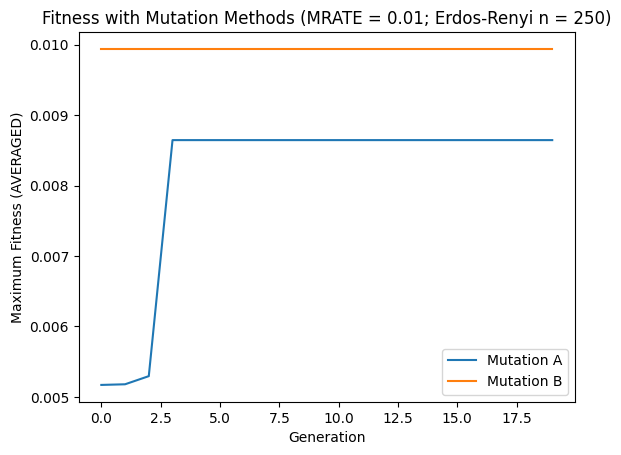

In [92]:
plt.figure()
plt.plot(fit_one_ma)
plt.plot(fit_one_mb)
plt.xlabel("Generation")
plt.ylabel("Maximum Fitness (AVERAGED)")
plt.legend(("Mutation A", "Mutation B"))
plt.title("Fitness with Mutation Methods (MRATE = 0.01; Erdos-Renyi n = 500)")
plt.show()

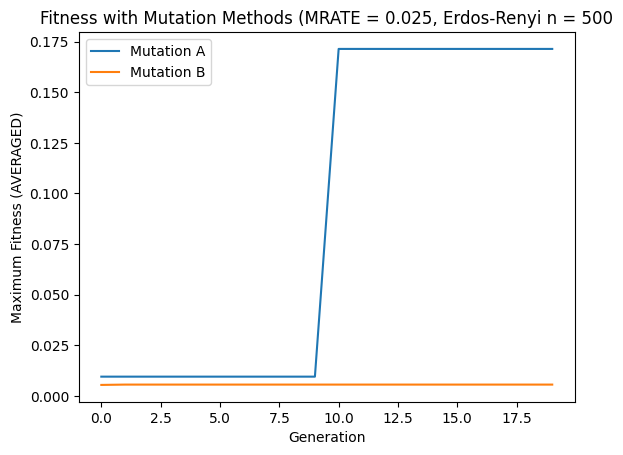

In [95]:
plt.figure()
plt.plot(fit_five_ma)
plt.plot(fit_five_mb)
plt.xlabel("Generation")
plt.ylabel("Maximum Fitness (AVERAGED)")
plt.legend(("Mutation A", "Mutation B"))
plt.title("Fitness with Mutation Methods (MRATE = 0.025, Erdos-Renyi n = 500")
plt.show()

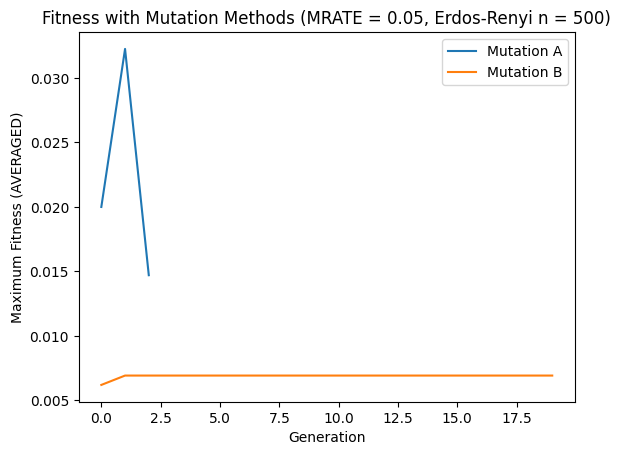

In [97]:
plt.figure()
plt.plot(fit_ten_ma)
plt.plot(fit_ten_mb)
plt.xlabel("Generation")
plt.ylabel("Maximum Fitness (AVERAGED)")
plt.legend(("Mutation A", "Mutation B"))
plt.title("Fitness with Mutation Methods (MRATE = 0.05, Erdos-Renyi n = 500)")
plt.show()

**Compare Computation Time**

In [106]:
import pandas as pd

runtime_one_ma = 0 
runtime_one_mb = 0
runtime_five_ma = 0
runtime_five_mb = 0
runtime_ten_ma = 0
runtime_ten_mb = 0

fitness_one_ma = 0
fitness_one_mb = 0
fitness_five_ma = 0
fitness_five_mb = 0
fitness_ten_ma = 0
fitness_ten_mb = 0

for i in range(3):
    runtime_one_ma += (results_one_ma[i]["runtime"] / 3)
    runtime_one_mb += (results_one_mb[i]["runtime"] / 3)
    runtime_five_ma += (results_five_ma[i]["runtime"] / 3)
    runtime_five_mb += (results_five_mb[i]["runtime"] / 3)
    runtime_ten_ma += (results_ten_ma[i]["runtime"] / 3)
    runtime_ten_mb += (results_ten_mb[i]["runtime"] / 3)
    
    fitness_one_ma += (results_one_ma[i]["fitness"] / 3)
    fitness_one_mb += (results_one_mb[i]["fitness"] / 3)
    fitness_five_ma += (results_five_ma[i]["fitness"] / 3)
    fitness_five_mb += (results_five_mb[i]["fitness"] / 3)
    fitness_ten_ma += (results_ten_ma[i]["fitness"] / 3)
    fitness_ten_mb += (results_ten_mb[i]["fitness"] / 3)

# Array data
runtime_data = [[runtime_one_ma, runtime_one_mb],
               [runtime_five_ma, runtime_five_mb],
               [runtime_ten_ma, runtime_ten_mb]]
fitness_data = [[fitness_one_ma, fitness_one_mb],
               [fitness_five_ma, fitness_five_mb],
               [fitness_ten_ma, fitness_ten_mb]]

# Pandas data frame
runtime_df = pd.DataFrame(data = runtime_data, columns = ['Mutation A', 'Mutation B'], 
                         index = ['MRATE 0.01', 'MRATE 0.025', 'MRATE 0.05'])
fitness_df = pd.DataFrame(data = fitness_data
                          , columns = ['Mutation A', 'Mutation B'],
                         index = ['MRATE 0.01', 'MRATE 0.025', 'MRATE 0.05'])


print("Average Runtime (seconds)")
print(runtime_df)
print("\n")
print("Average Fitness")
print(fitness_df)

Average Runtime (seconds)
             Mutation A  Mutation B
MRATE 0.01    27.035280   30.139262
MRATE 0.025   62.006782   45.070714
MRATE 0.05    89.749459   40.441910


Average Fitness
             Mutation A  Mutation B
MRATE 0.01     0.008645    0.009940
MRATE 0.025    0.171397    0.005570
MRATE 0.05     0.022321    0.006922
